In [31]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import chi2
from scipy import stats
from scipy.stats import binom_test

In [2]:
df = pd.read_csv(r'C:\Users\bsalahli\Intel\modeling\sample_data CRM.csv')
df['reporting_date'] = pd.to_datetime(df['reporting_date'])

C:\Users\bsalahli\AppData\Local\Temp\ipykernel_6064\2772797383.py:2: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['reporting_date'] = pd.to_datetime(df['reporting_date'])


In [3]:
# The PDs have already been adjusted for ratings.
# If one particular rating has the same PDs, it indicates that it has already been adjusted.
# However, it is still possible for customers to have the same ratings with different PDs.
# but In that cases, it is not observable due to a lack of data.

def adjusted_or_not(df,column,column_unique):
    for x in list(df[column].unique()):
        rating_data = df[df[column]==x]
        if rating_data[column_unique].nunique()>1:
            print("not adjusted for",x)
        else:
            print('it is already adjusted for',column)
adjusted_or_not(df,'mrating','PD')

it is already adjusted for mrating
it is already adjusted for mrating
it is already adjusted for mrating
it is already adjusted for mrating
it is already adjusted for mrating
it is already adjusted for mrating
it is already adjusted for mrating
it is already adjusted for mrating
it is already adjusted for mrating
it is already adjusted for mrating
it is already adjusted for mrating
it is already adjusted for mrating
it is already adjusted for mrating
it is already adjusted for mrating
it is already adjusted for mrating
it is already adjusted for mrating


# Average PD calculation

In [4]:
# beacuse we do not have sufficient data to calculate more sophisticated average PD,I will use simple approach.
# I could calculate W.A pd, but to do it I need maturities of loans, lifetime PD and payment schedule.
# and given that PD are already adjusted for ratings, I will only calculate mean of PD for each customer
# to get average PD.

average_pd_per_customer = df.groupby('customer_id')['PD'].mean().reset_index()

average_pd_per_customer['PD'] = average_pd_per_customer['PD'].round(2)  

average_pd_per_customer.rename(columns={'PD': 'Average_PD'}, inplace=True)

data = df.merge(average_pd_per_customer, on='customer_id', how='left')

# explanation of how the distribution of defaults given the ASRF model may differ from that under the assumption they are binomially distributed 

In [ ]:
The distribution of defaults under the ASRF model differs from that assumed 
in the binomial distribution because he ASRF model incorporates varying success and 
failure rates (PDs) for each customer,whereas the binomial distribution assumes a single
uniform success rate.


As a result, the distribution of defaults in the ASRF model accounts for the individual credit risk
profiles of each customer,resulting in a more realistic representation of credit risk. In contrast,
the binomial distribution assumes a uniform, independent and constant risk level for all customers,
which may not accurately capture the varying levels of credit risk inherent in a diverse portfolio.

# explanation of how to compare the observed default ratio to the PD using binomial.

In [ ]:
To test the predicted Probability of Default (PD) against a realized series of observed default rates,
we can employ various statistical tests. 
While we assume the Null Hypothesis (that the predicted PD accurately reflects the
average probability of default for obligors in the group), 
the choice of the statistical test depends on the distribution of the data. 
If the data follows a normal distribution, a t-test or other parametric tests are appropriate;
otherwise, we can use other non-parametric tests. 
This process involves identifying degrees of freedom, selecting a Significance Level 
and ultimately comparing the calculated p-value to the chosen Significance Level.

As an example, I have utilized the binomial test, which is explained below.

In [6]:
# This function helps analyze the relationship between model predictions and  actual target values
# by aggregating them into bins and calculating summary statistics within each bin.
# This methos is useful for analyzing the model's performance across different bins or score ranges.
def binomial(data,target,pred, n_bins = 10, obs_col='num_obs'):
    df = pd.concat([target, pred], axis=1)
    df[obs_col] = 1 # This column is intended to represent the count of observations.
    min_ = min(pred)
    max_ = max(pred)
    bins = np.append(np.arange(min_, max_, (max_-min_)/n_bins), max_)
    # This line calculates the bin edges for the specified number of bins (n_bins)
    
    df[pred.name + '_binned'] = pd.cut(pred, bins, include_lowest=True)
    df = df.groupby(pred.name + '_binned', as_index=False).agg({target.name:'sum',obs_col:'count',
                                                                pred.name:'mean'})
    # this line calculates the sum of target, the count of observations. 
    df[pred.name + '_binned'] = df[pred.name + '_binned'].apply(lambda x: pd.Interval(
                                left=round(x.left,3),right=round(x.right,3)))
    df['target_rate'] = df[target.name] / df[obs_col]
    #This line calculates the target rate, which is the ratio of the sum of target values to the count of observations (obs_col) within each bin.
    df['weight_of_bin'] = df[target.name]/df[target.name].sum()
    df['weighted_recall'] = (df[pred.name]/df['target_rate'])* df['weight_of_bin']
    
    return df.dropna().round(2) , df['weighted_recall'].sum()
    

In [7]:
result , recall = binomial(data,data.intodefault,data.PD)

In [193]:
print('roughly weighted recall:',round(recall*100),"%")

roughly weighted recall: 43 %


In [9]:
result

,PD_binned,intodefault,num_obs,PD,target_rate,weight_of_bin,weighted_recall
0,"(0.0, 0.046]",2263,20569,0.02,0.11,0.25,0.04
1,"(0.046, 0.091]",1489,7202,0.07,0.21,0.16,0.06
3,"(0.136, 0.181]",1860,6102,0.15,0.30,0.20,0.10
4,"(0.181, 0.226]",1014,2568,0.20,0.39,0.11,0.06
5,"(0.226, 0.27]",946,2269,0.25,0.42,0.10,0.06
6,"(0.27, 0.315]",760,1560,0.30,0.49,0.08,0.05
7,"(0.315, 0.36]",493,858,0.36,0.57,0.05,0.03
9,"(0.405, 0.45]",278,551,0.45,0.50,0.03,0.03


# compare the observed default ratio to the PD using confision matrix

In [ ]:
# to use confision matrix, we should first define threshold

In [81]:
def identify_threshold(data,actual,pred):
    predicted_probs = data[pred]
    actual_labels = data[actual]
    thresholds = [0.05, 0.10, 0.15,0.20 ,0.25, 0.3, 0.35, 0.4] #list of thresholds
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for threshold in thresholds:
        # Convert predicted probabilities to binary predictions based on the threshold
        binary_predictions = (predicted_probs >= threshold).astype(int)

        # Calculate accuracy, precision, and recall for the threshold
        accuracy = accuracy_score(actual_labels, binary_predictions)
        precision = precision_score(actual_labels, binary_predictions)
        recall = recall_score(actual_labels, binary_predictions)
        f1 = f1_score(actual_labels, binary_predictions)
        # Append the calculated metrics to the respective lists
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
    # Create a DataFrame to store the results
    results_df = pd.DataFrame({'Threshold': thresholds, 'Accuracy': accuracy_scores, 
                                'Precision': precision_scores, 'Recall': recall_scores, 'F1 Score': f1_scores})
    return results_df


In [82]:
results_df = identify_threshold(data,'intodefault','PD')

In [83]:
results_df

,Threshold,Accuracy,Precision,Recall,F1 Score
0,0.05,0.603325,0.324017,0.751401,0.452785
1,0.10,0.704671,0.384743,0.587828,0.465082
2,0.15,0.737614,0.413153,0.478963,0.443630
3,0.20,0.761823,0.447220,0.383500,0.412916
4,0.25,0.774779,0.472890,0.272108,0.345443
5,0.30,0.783824,0.515662,0.168186,0.253645
6,0.35,0.784784,0.547197,0.084697,0.146689
7,0.40,0.781713,0.504537,0.030539,0.057593


In [13]:
# The threshold of 0.15 is the most suitable choice
# since it matches  the average PD rate of customers who have defaulted.
data[data['intodefault']==1]['PD'].mean()

0.15451180929363947

In [14]:
# Additionally, given that our primary objective is to identify customers who may default, 
# we should primarily focus on increasing recall to optimal level."
# Finally, The recall value obtained from both the binomial test and the last method are similar
results_df[results_df['Threshold']==0.15]

,Threshold,Accuracy,Precision,Recall,F1 Score
0,0.15,0.737614,0.413153,0.478963,0.44363


# whether the observed average default rate is within the expected range.

In [15]:
df = data.copy()

In [16]:
#To calculate the average observed target rate, 
#I chose to calculate a weighted average of the observed default rate based on 
#the customer's default_moment.
#This accounts for the fact that customers who defaulted more recently are considered riskier.
#I accomplished this by creating a new column that calculates the 
#time difference between default_moment and the current date."

df.default_moment = pd.to_datetime(df.default_moment)
df['since_defaulted'] = round(((datetime.now() - df.default_moment).dt.days)/30)
sum_days = df.groupby('customer_id')['since_defaulted'].sum().reset_index()
sum_days.rename(columns = {'since_defaulted':'sum_days'} , inplace = True)
sumed = df.merge(sum_days, on = 'customer_id' , how = 'left')
data['weights_of_defaults'] = sumed['since_defaulted']/sumed.sum_days
data['adjusted_defaults'] = data['intodefault'] * data['weights_of_defaults']
last = data.groupby('customer_id')['adjusted_defaults'].sum().reset_index()
last = last.rename(columns = {'adjusted_defautls':'weighted_default_rates'})
last.rename(columns = {'adjusted_defaults':'weighted_default_rates'} , inplace = True)
data = data.merge(last , on = 'customer_id' , how = 'left')
data.drop(columns = ['adjusted_defaults','weights_of_defaults'] , axis = 1 , inplace = True)

C:\Users\bsalahli\AppData\Local\Temp\ipykernel_6064\31461935.py:8: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df.default_moment = pd.to_datetime(df.default_moment)


In [17]:
result_average , recall_average = binomial(data,data.weighted_default_rates,data.Average_PD)

In [194]:
data

,customer_id,reporting_date,default_moment,intodefault,mrating,PD,Average_PD,weighted_default_rates,EDR,ODR
0,1,2010-01-31,30.09.2010,1,21,0.20,0.24,1.0,8335.80,1
1,1,2010-02-28,30.09.2010,1,22,0.25,0.24,1.0,10419.75,1
2,1,2010-03-31,30.09.2010,1,22,0.25,0.24,1.0,10419.75,1
3,1,2010-04-30,30.09.2010,1,22,0.25,0.24,1.0,10419.75,1
4,1,2010-05-31,30.09.2010,1,22,0.25,0.24,1.0,10419.75,1
...,...,...,...,...,...,...,...,...,...,...
41674,2501,2011-07-31,NaN,0,17,0.06,0.05,0.0,2500.74,0
41675,2501,2011-08-31,NaN,0,17,0.06,0.05,0.0,2500.74,0
41676,2501,2011-09-30,NaN,0,17,0.06,0.05,0.0,2500.74,0
41677,2501,2011-10-31,NaN,0,17,0.06,0.05,0.0,2500.74,0


In [18]:
print('weighted recall:',round(recall_average*100),"%")

weighted recall: 36 %


In [19]:
result_average

,Average_PD_binned,weighted_default_rates,num_obs,Average_PD,target_rate,weight_of_bin,weighted_recall
0,"(-0.001, 0.045]",2633.62,19795,0.02,0.13,0.24,0.03
1,"(0.045, 0.09]",1610.69,6720,0.07,0.24,0.15,0.04
2,"(0.09, 0.135]",710.31,2678,0.11,0.27,0.07,0.03
3,"(0.135, 0.18]",1907.08,4866,0.16,0.39,0.18,0.07
4,"(0.18, 0.225]",1075.38,2422,0.20,0.44,0.10,0.05
5,"(0.225, 0.27]",1146.00,2225,0.25,0.52,0.11,0.05
6,"(0.27, 0.315]",728.08,1265,0.29,0.58,0.07,0.03
7,"(0.315, 0.36]",594.00,929,0.34,0.64,0.05,0.03
8,"(0.36, 0.405]",165.00,316,0.38,0.52,0.02,0.01
9,"(0.405, 0.45]",284.54,463,0.44,0.61,0.03,0.02


In [ ]:
# because Classification metrics can't handle a mix of continuous and binary targets
# we can't use identify_threshold for weighted_default_rates

## Hosmer_Lemeshow test

In [20]:
#Hosmer-Lemeshow Chi-Square test checks whether the difference between 
#the actual and modelled outcome at the portfolio level 
#(i.e., simultaneously for all grades), is statistically significant over 
#the assessment period. The test is performed at an overall model level and
#does not inform about the underestimation or the overestimation.
def Hosmer_Lemeshow(target,pred,obs_col='num_obs',n_bins=10,bins_col=None):

    df = pd.concat([target, pred,bins_col], axis=1)
    df['num_obs'] = 1
    min_ = min(pred)
    max_ = max(pred)
    bins = np.append(np.arange(min_, max_, (max_-min_)/n_bins), max_) 
    df[pred.name + '_binned'] = pd.cut(pred, bins, include_lowest=True)
    df = df.groupby(pred.name + '_binned', as_index=False).agg({target.name:'sum','num_obs':'count',
                                                                        pred.name:'mean'})
    df['exp_events'] = df[obs_col]*df[pred.name]
    tt = sum((df['exp_events']-df[target.name])**2/(df['exp_events']*(1-df[pred.name])))
    chi = chi2.cdf(tt,len(df)-2)
    pvalue=1-chi
    return pvalue

In [27]:
Hosmer_Lemeshow(data.weighted_default_rates,data.Average_PD)

0.0

In [177]:
data

,customer_id,reporting_date,default_moment,intodefault,mrating,PD,Average_PD,weighted_default_rates,EDR,ODR
0,1,2010-01-31,30.09.2010,1,21,0.20,0.24,1.0,8335.80,1
1,1,2010-02-28,30.09.2010,1,22,0.25,0.24,1.0,10419.75,1
2,1,2010-03-31,30.09.2010,1,22,0.25,0.24,1.0,10419.75,1
3,1,2010-04-30,30.09.2010,1,22,0.25,0.24,1.0,10419.75,1
4,1,2010-05-31,30.09.2010,1,22,0.25,0.24,1.0,10419.75,1
...,...,...,...,...,...,...,...,...,...,...
41674,2501,2011-07-31,NaN,0,17,0.06,0.05,0.0,2500.74,0
41675,2501,2011-08-31,NaN,0,17,0.06,0.05,0.0,2500.74,0
41676,2501,2011-09-30,NaN,0,17,0.06,0.05,0.0,2500.74,0
41677,2501,2011-10-31,NaN,0,17,0.06,0.05,0.0,2500.74,0


In [ ]:
# p value is less than 0.05
# So, a significance difference exists between estimated and observed outcome in at least one of the grades

# •	Discriminatory power 

In [ ]:
# first of all, before draw a ROC curve and Calculate the Area under the Curve (AUC) 
# I would like to calculate gini index which is very effective way to test 
# Discriminatory power of the model

In [181]:
def Gini(target, pred,):

    fpr, tpr, thresholds = roc_curve(target, pred)
    roc_auc = auc(fpr, tpr)
    GINI = (2 * roc_auc) - 1
    return GINI


In [182]:
Gini(data.intodefault , data.PD)

0.42259413564193427

#  calculating auc and ploting roc curve

In [43]:
def calculate_auc(target, probabilities):
    fpr, tpr, _ = roc_curve(target, probabilities)
    return auc(fpr, tpr)

In [185]:
auc_data = calculate_auc(data.intodefault , data.PD)
auc_data

0.7112970678209671

In [37]:
def plot_roc_curve(target, probabilities):
    fpr, tpr, _ = roc_curve(target, probabilities)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

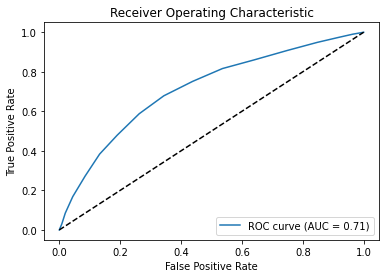

In [38]:
plot_roc_curve(data.intodefault , data.PD)

In [ ]:
# The AUC is a rank measure, which means it abstracts from the differences in
# the probability scores and only looks at too which extend the
# target observations are ranked above non-target observations

# 	Could you explain the test rationale and interpret its value? (If you cannot calculate the test statistic: what would test statistic value of 1.9 mean? The same for S = -1.5)

In [189]:
initial_AUC = 0.75

In [ ]:
A Z-score of 1.9 indicates that the initial AUC is 1.9 standard deviations above
the current AUC of 0.71. This suggests strong evidence that initial AUC is better than current.

A Z-score of -1.5 indicates that the initial AUC is 1.5 
standard deviations below the current AUC. 
This suggests strong evidence that your model AUC is worse than current AUC.

# binomial test

In [162]:
# Perform a binomial test to check if ODR is significantly different from EDR
p_value = binom_test(data['intodefault'].sum(), n=data.shape[0], p=data['PD'].mean())

# Check if the p-value is less than alpha to determine statistical significance
if p_value < 0.05:
    print("The observed default rates are significantly different from the expected range.")
else:
    print("The observed default rates are consistent with the expected range.")


The observed default rates are significantly different from the expected range.


In [176]:
data['EDR'] = data['PD'] * data.shape[0]
print(data['ODR'].sum())
print(round(data['EDR'].mean()))
print('roughly recall:',data['EDR'].mean() / data['ODR'].sum() )

9103
3903
roughly recall: 0.4287783148412611


# Mann-Whitney U statistic

In [143]:
# calculation of Mann-Whitney U statistic to check discriminatory power of the model.
group1_probs = data[data['intodefault']==1]['PD'].to_list()
group2_probs = data[data['intodefault']==0]['PD'].to_list()

# Calculate the Mann-Whitney U statistic and p-value
U_statistic, p_value = stats.mannwhitneyu(group1_probs, group2_probs, alternative='two-sided')

print(f"Mann-Whitney U statistic: {U_statistic}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The groups have significantly different distributions.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in distributions.")


Mann-Whitney U statistic: 210927554.5
P-value: 0.0
Reject the null hypothesis: The groups have significantly different distributions.


# •	Please show / argue how your answer would change if instead the PDs are the corresponding parameter of the ASRF model. You can assume fixed asset correlation of 15%.

In [ ]:
Because we do not have access to maturity, EAD, and LGD, 
my answer can change significantly due to the presence of correlation.

In the case of customers who have a fixed asset correlation,
Asset correlation can influence the joint behavior of defaults in a portfolio,
potentially leading to changes in the overall default rates and the way we assess credit risk.